In [1]:
import random 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from kaggle_environments import make, evaluate
from gym import spaces

from heuristic_agent import rival

#creacio del environment on entrenarem la nostra xarxa neuronal
class ConnectFourGym:
    def __init__ (self, agent2=rival):
        ks_env = make("connectx", debug=True)
        self.env = ks_env.train([None, agent2])
        self.rows = ks_env.configuration.rows
        self.columns = ks_env.configuration.columns
        
        self.action_space = spaces.Discrete(self.columns)
        self.observation_space = spaces.Box(low=0, high=2, shape=(self.rows, self.columns, 1), dtype=np.int)
        
        self.reward_range = (-10, 1)
        
        self.spec = None
        self.metadata = None
    
    def reset (self):
        self.obs = self.env.reset()
        return np.array(self.obs['board']).reshape(self.rows, self.columns, 1)
    
    def change_reward (self, old_reward, done):
        if old_reward == 1:
            return 1
        elif done:
            return -1
        else:
            return 1/(self.rows * self.columns)
    
    def step(self, action):
        is_valid = (self.obs['board'][int(action)] == 0)
        if is_valid:
            self.obs, old_reward, done, _ = self.env.step(int(action))
            reward = self.change_reward(old_reward, done)
        else:
            reward, done, _ = -10, True, {}
        return np.array(self.obs['board']).reshape(self.rows, self.columns, 1), reward, done, _

Loading environment football failed: No module named 'gfootball'


In [2]:
#jugador amb el que entrenarem la nostra xarxa
env = ConnectFourGym(agent2=rival)

In [3]:
import os
from stable_baselines.bench import Monitor 
from stable_baselines.common.vec_env import DummyVecEnv

log_dir = "ppo/"
os.makedirs(log_dir, exist_ok=True)
monitor_env = Monitor(env, log_dir, allow_early_resets=True)
vec_env = DummyVecEnv([lambda: monitor_env])

In [4]:
#creacio del nostre model amb PPO1
from stable_baselines import PPO1 
from stable_baselines.a2c.utils import conv, linear, conv_to_fc
from stable_baselines.common.policies import CnnPolicy

def modified_cnn(scaled_images, **kwargs):
    activ = tf.nn.relu
    layer_1 = activ(conv(scaled_images, 'c1', n_filters=32, filter_size=3, stride=1, 
                         init_scale=np.sqrt(2), **kwargs))
    layer_2 = activ(conv(layer_1, 'c2', n_filters=64, filter_size=3, stride=1, 
                         init_scale=np.sqrt(2), **kwargs))
    layer_2 = conv_to_fc(layer_2)
    return activ(linear(layer_2, 'fc1', n_hidden=512, init_scale=np.sqrt(2)))  

class CustomCnnPolicy(CnnPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomCnnPolicy, self).__init__(*args, **kwargs, cnn_extractor=modified_cnn)
        
model = PPO1(CustomCnnPolicy, vec_env, verbose=0)

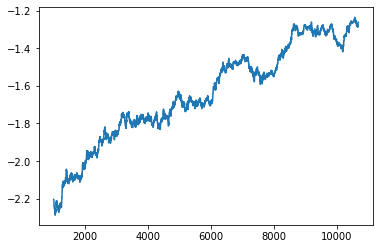

In [5]:
#entrenament de la red neuronal
model.learn(total_timesteps=100000)

#grafica amb els resultats dels entrenaments
#quan mes a pror del 1 jugara millor
with open(os.path.join(log_dir, "monitor.csv"), 'rt') as fh:    
    firstline = fh.readline()
    assert firstline[0] == '#'
    df = pd.read_csv(fh, index_col=None)['r']
df.rolling(window=1000).mean().plot()
plt.show()

In [6]:
#la nostra red neuronal
def agent(obs, config):
    #agafa la millor columna
    col, _ = model.predict(np.array(obs['board']).reshape(6,7,1))
    #si el moviment no es valid fara un moviment aleatori
    is_valid = (obs['board'][int(col)] == 0)
    if is_valid:
        return int(col)
    else:
        return random.choice([col for col in range(config.columns) if obs.board[int(col)] == 0])


In [8]:
# crear el joc
env = make("connectx")

env.play([None, agent])